# Introduction to NetworkX in Python

Networks enable questions about connectivity, for example: shortest path, centrality, sources and sinks, and rate of flow (Kuhn, 2012). By referencing these core concepts in the spatializations that we implement, we are able to extend the powerful idea of spatial search to spatialized themes and enable scholars to explore the relatedness of research.

In order to enable the discovery of related research, we implemented several spatializations of research themes. The steps we took to do so are summarized as follows:
- Harvest the metadata of research theses
- Assign themes to documents using topic modeling on metadata
- Spatialize themes using existing spatialization algorithms
- Implement a network view

These are the packages we will use to construct the network:

In [195]:
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import networkx as nx

Our first example of a graph will be an empty graph. To see the proper mathematical definition of a graph, you can have a look at our previous chapter Graphs in Python. The following little Python script uses NetworkX to create an empty graph:

In [196]:
import networkx as nx

G=nx.Graph()

print(G.nodes())
print(G.edges())

print(type(G.nodes()))
print(type(G.edges()))

[]
[]
<class 'networkx.classes.reportviews.NodeView'>
<class 'networkx.classes.reportviews.EdgeView'>


## Adding Nodes to the graph

Now we will add some nodes to our graph. We can add one node with the method add_node() and a list of nodes with the method add_nodes_from():

In [197]:
# adding just one node:
G.add_node("a")
# a list of nodes:
G.add_nodes_from(["b","c"])

print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

Nodes of graph: 
['a', 'b', 'c']
Edges of graph: 
[]


## Adding Edges to the graph

G can also be created or increased by adding one edge at a time by the method add_edge(), which has the two nodes of the edge as the two parameters. If we have a tuple or a list as the edge, we can use the asterisk operator to unpack the tuple or the list:

In [198]:
G.add_edge(1,2)
edge = ("d", "e")
G.add_edge(*edge)
edge = ("a", "b")
G.add_edge(*edge)

print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

Nodes of graph: 
['a', 'b', 'c', 1, 2, 'd', 'e']
Edges of graph: 
[('a', 'b'), (1, 2), ('d', 'e')]


We can add a bunch of edges as a list of edges in the form of 2 tuples.

In [199]:
# adding a list of edges:
G.add_edges_from([("a","c"),("c","d"), ("a",1), (1,"d"), ("a",2)])

We can also print the resulting graph by using matplotlib:

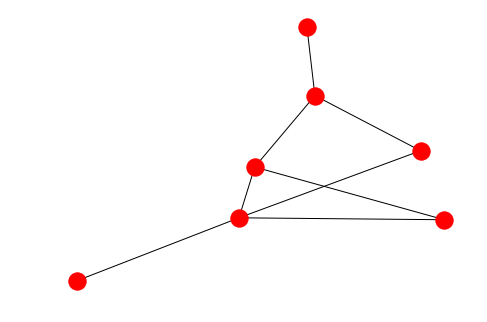

In [200]:
nx.draw(G)
plt.savefig("simple_path.png") # save as png
plt.show() # display

## Using data from UCSB student thesis metadata

We focus on resources accessible through the Alexandria Digital Research Library (ADRL), which is curated by the UC Santa Barbara Library. We first created a list of nodes and edges from the metadata. A node list is a set of objects that consists of a list of all the individual dissertations (nodes) and their attributes, including:
- Title
- Year
- Author
- Degree Grantor
- Supervisor
- Department

An edge list is a set of objects that consists of all possible pairings between nodes. Our edge list contains additional columns that describe the attributes of an edge, such as the strength of topical correspondence.

We will make use of some data description packages first.

In [257]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10

For example, let's start by reading in data sampled from ADRL (adapted from https://alexandria.ucsb.edu/collections/f3348hkz). To inspect the data:

In [211]:
df = pd.read_csv('ADRL_2.csv', delimiter = ',', low_memory=False)
df.head()

,Unnamed: 0,id,identifier,topic_num,weight,title,year,author,degree_supervisor,description,...,topic_num1,weight1,title1,year1,author1,degree_supervisor1,description1,Department1,source,target
0,1,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",Rouslan Krechetnikov,"In this work, several case studies involving c...",...,topic7,0.047378,"Wings Well Braced with Bone : Ibsen, Gender, a...",2016,"Jensen, Anna",Simon Williams,Scholarship on Henrik Ibsen has long noted his...,Theater Studies,0,2
1,2,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",Rouslan Krechetnikov,"In this work, several case studies involving c...",...,topic7,0.029882,Consciousness and Resistance in Chicano Barrio...,2016,"Nez, Ana Arellano",Francisco A. Lomeli,Chicano barrios in the U.S. are commonly repre...,Comparative Literature,0,3
2,3,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",Rouslan Krechetnikov,"In this work, several case studies involving c...",...,topic7,0.050193,Three Essays on the Economics of Fisheries Man...,2016,"Toseland, Rebecca Ellen",Christopher Costello,Problems arising from the common-pool nature o...,Department of Economics,0,13
3,4,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",Rouslan Krechetnikov,"In this work, several case studies involving c...",...,topic7,0.001347,"Guca : An Account of the Phonetics, Phonotacti...",2016,"Siemens, Rebekka S.",Dr. Carol Genetti,"The topic of this dissertation is Guca, a dial...",Linguistics,0,15
4,5,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",Rouslan Krechetnikov,"In this work, several case studies involving c...",...,topic7,0.230535,Physiological Responses to Perceived Exergame ...,2016,"Cornick, Jessica E.",James Blascovich,Exercise videogames are increasingly popular a...,Psychology,0,18


To start, we randomly sample without replacement 50 nodes from the total 1,731. By sampling 50, we reduce complexity within the network, yet still retain topical and departmental diversity.

In [232]:
df1 = df.groupby('id')
df2 = df1.apply(lambda x: x.sample(n=10, replace=True))
df2.to_csv('df2.csv', sep=',')

This table gives details of the Title, Year, Author, Degree Grantor, Supervisor and Department for each 50 sampled dissertations. Edges are constructed between nodes which share a strong topical coherence. Strength is defined by any sampled node that shares a top three topic with another node in the ADRL dataset. To do this, we create all possible identifier topic pairings from the sampled node list to the original ADRL data (only retaining one match in each direction as we do not want repeat matchings). From this, only retain pairs with different identifiers but the same topic. This procedure leaves duplicates where identifiers have multiple top three topics in common. The same details (e.g. Author1) have been kept for the linked dissertations brought into the network through the shared topic relationship.

In [231]:
df3 = pd.read_csv('df2.csv', delimiter = ',')
df4 = df3[0:500]
df4.head()

,id,Unnamed: 1,Unnamed: 0,id.1,identifier,topic_num,weight,title,year,author,...,topic_num1,weight1,title1,year1,author1,degree_supervisor1,description1,Department1,source,target
0,0,7,8,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",...,topic7,0.282608,An Expectancy Violations Theory and Social Ide...,2016,"Nicholls, Spencer Byron",Ronald E. Rice,Deviance from normative behavior is not only p...,Communication,0,62
1,0,98,99,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",...,topic7,0.001874,Stress-Relaxation in III-Nitride Based Semipol...,2013,"Hsu, Po Shan",Shuji Nakamura,Semipolar growth orientations of wurtzite III-...,Materials,0,924
2,0,125,126,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",...,topic7,0.073657,Decoding human sensorimotor transformations fo...,2013,"Barany, Deborah Adina",Scott T. Grafton,Neurophysiology and neuroimaging evidence sugg...,Psychology,0,1176
3,0,111,112,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",...,topic7,0.006168,Transport Processes at the Air/Liquid Interfac...,2013,"Rezaei Barmi, Meysam",Carl D. Meinhart,The investigation of the transport processes a...,Mechanical Engineering,0,1054
4,0,53,54,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",...,topic7,0.147207,Awareness of Observation Affects Resting State...,2014,"Li, Jing",Michael B. Miller,Functional imaging studies have revealed the d...,Psychology,0,492


In [214]:
g = nx.from_pandas_edgelist(df4, source='source', target='target')

In [215]:
cmap = plt.cm.RdYlGn
colors = [n for n in range(len(g.nodes()))]

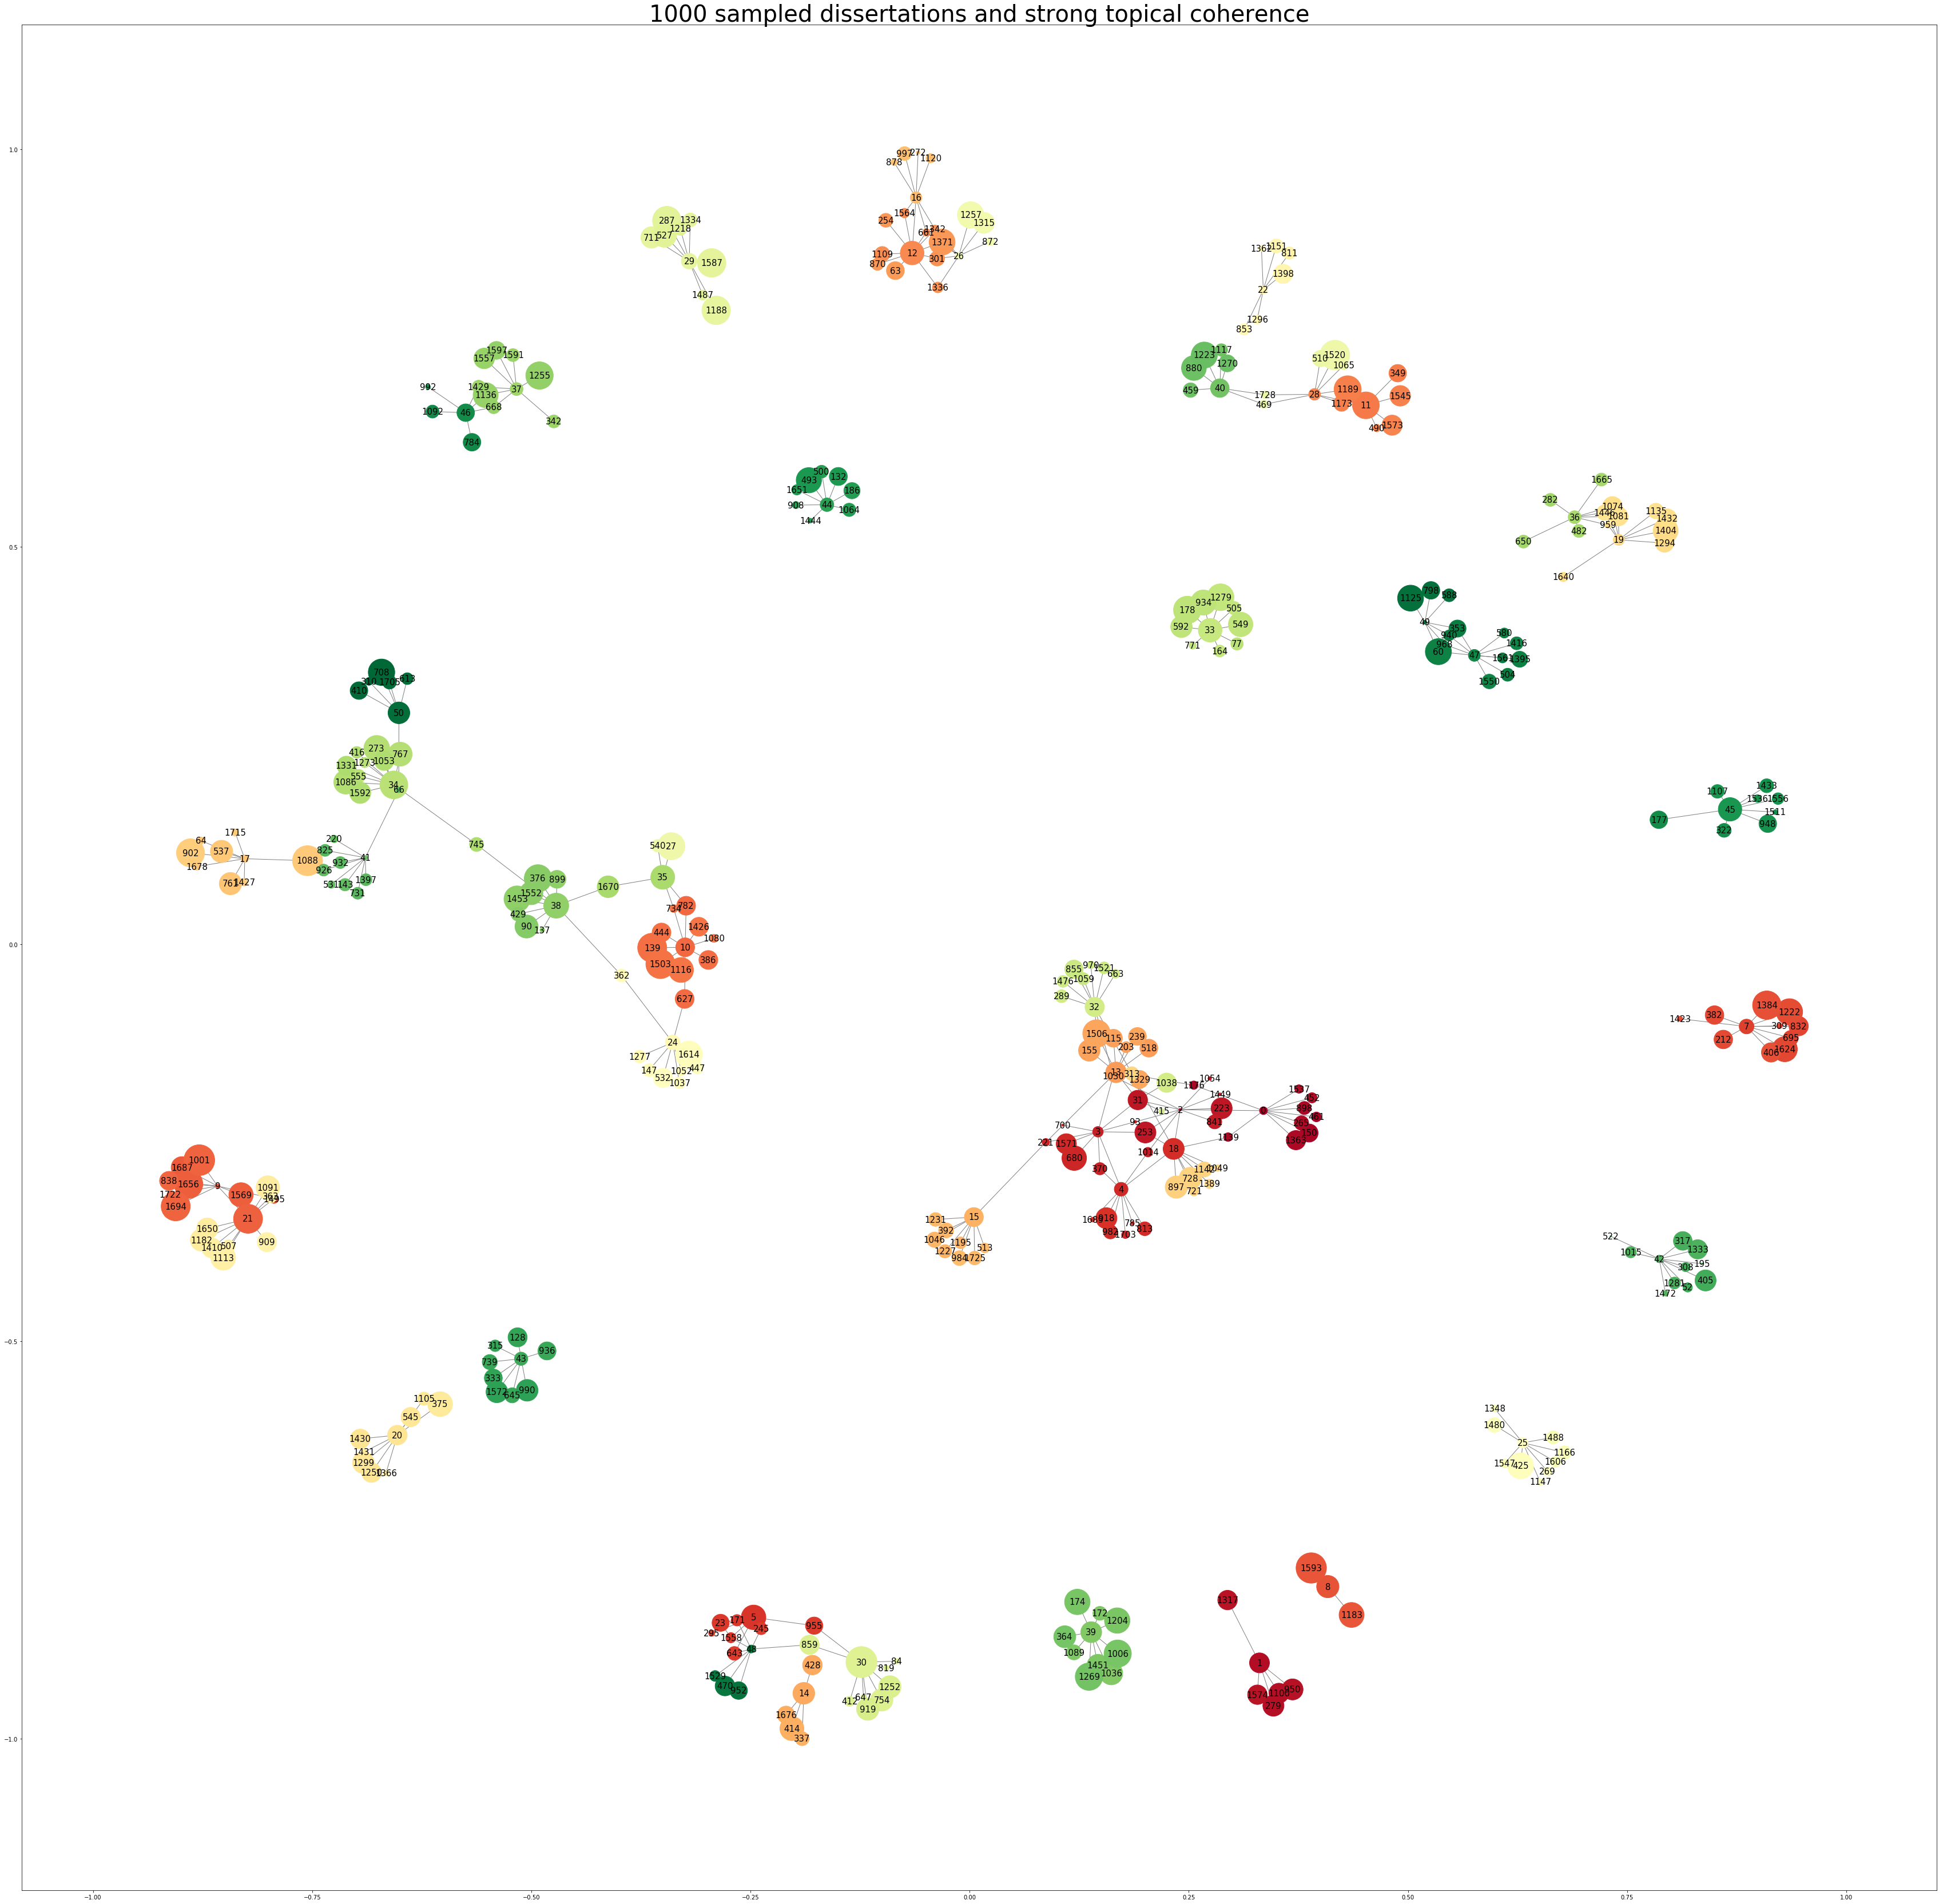

In [216]:
nx.draw_networkx(g, node_size = df4['weight1'].values * 4000, edge_color = 'grey', cmap = cmap, node_color = colors, font_size = 15, width = 1)
plt.title("500 sampled dissertations and strong topical coherence", fontsize = 40)
plt.gcf().set_size_inches(60, 60)
plt.show()

The graph shows the 500 sampled nodes from the ADRL data. These nodes are embedded and located using their topic weight. This centralises nodes that have a low topic weighting, and the further out the node is embedded, the strong the topical coherence and the more the node is an outlier (in terms of it focussing on a niche topic). 

Edges are constructed between nodes which share a strong topical coherence. This strength is defined by any sampled node that shares a top three topic with another node in the ADRL dataset. To do this, we create all possible identifier topic pairings from the sampled node list to the original ADRL data (only retaining one match in each direction as we do not want repeat matchings). From this, only retain pairs with different identifiers but the same topic. This procedure leaves duplicates where identifiers have multiple top three topics in common.

# Comparing Networks to Self Organising Maps
Now we will select key nodes to understand the similarities and differences of spatialising tabular data in Self Organising Maps and Networks.

In [260]:
df5 = pd.read_csv('df2.csv', delimiter = ',', index_col = 14)
df5.head()

,id,Unnamed: 1,Unnamed: 0,id.1,identifier,topic_num,weight,title,year,author,...,topic_num1,weight1,title1,year1,author1,degree_supervisor1,description1,Department1,source,target
identifier1,,,,,,,,,,,,,,,,,,,,,
f3xd0znd,0,168,169,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",...,topic7,0.144190,Implications of Engineered Nanomaterials in Ma...,2012,"Hanna, Shannon Kareem",Hunter S. Lenihan,"Nanotechnology, the ability to manipulate matt...",Environmental Science and Management,0,1631
f3s46q1q,0,149,150,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",...,topic7,0.028130,Ruling in Ancient Greece and India: A Historic...,2012,"Gray, Stuart James",Paige Digeser,This dissertation establishes a new analytic a...,Political Science,0,1382
f3gf0rms,0,121,122,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",...,topic7,0.103049,TraJECT-3D: Track and Junction Based Exploit o...,2013,"Pakbaz, Ryan Michael",Volkan Rodoplu,This thesis presents TraJECT-3D (Track and Jun...,Electrical and Computer Engineering,0,1153
f3r49nwx,0,45,46,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",...,topic7,0.247196,Influences on legislative behavior: Party unit...,2014,"Diaz Gomez, Everardo Rodrigo",Kathleen Bruhn,Influences over individual and collective beha...,Political Science,0,420
f3rj4gf8,0,99,100,0,f3bz65v3,topic7,0.100322,Complex short-time and small-scale behavior of...,2016,"Mayer, Hans C.",...,topic7,0.360850,Examining and Predicting Longitudinal Trajecto...,2013,"Chin, Jenna K.",Erin Dowdy,Educational researchers and practitioners are ...,Psychology,0,934


In [259]:
#Selecting columns identifier1, title1, Department1
cluster = df5.loc[['f3zw1j1w','f3rf5rzn','f3ms3qvb','f3pg1pw4','f3ws8rfr','f36h4fms','f3wh2mxb','f3jm27tc','f3m61h6q'], ['title1', 'Department1']]
cluster

,title1,Department1
identifier1,,
f3zw1j1w,Adding judgments of understanding and problem-...,Psychology
f3zw1j1w,Adding judgments of understanding and problem-...,Psychology
f3zw1j1w,Adding judgments of understanding and problem-...,Psychology
f3zw1j1w,Adding judgments of understanding and problem-...,Psychology
f3zw1j1w,Adding judgments of understanding and problem-...,Psychology
...,...,...
f3m61h6q,Composition Context Photography,Computer Science
f3m61h6q,Composition Context Photography,Computer Science
f3m61h6q,Composition Context Photography,Computer Science


We chose to assign dissertations the role of nodes. A node list is a set of objects that consists of a list of all the individual dissertations (nodes). Selecting the following nodes:
- f3zw1j1w' (Computer Science)
- 'f3rf5rzn' (Religious Studies)
- 'f3ms3qvb' (Media Arts and Technology)
- 'f3pg1pw4' (Religious Studies)
- 'f3ws8rfr' (History)
- 'f36h4fms' (Music)
- 'f3wh2mxb' (Sociology)
- 'f3jm27tc' (Electrical and Computer Engineering)
- 'f3m61h6q' (Computer Science - Engineering)

enables us to compare the results of the Self-Organising Map and the Network. Code adapted from https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labeling/14667533

# Issue
If clusters need to be items are already in graph g and then should call nx.draw_networkx with labels set to dictionary that have keys as clusters nodes and values as labels/strings.

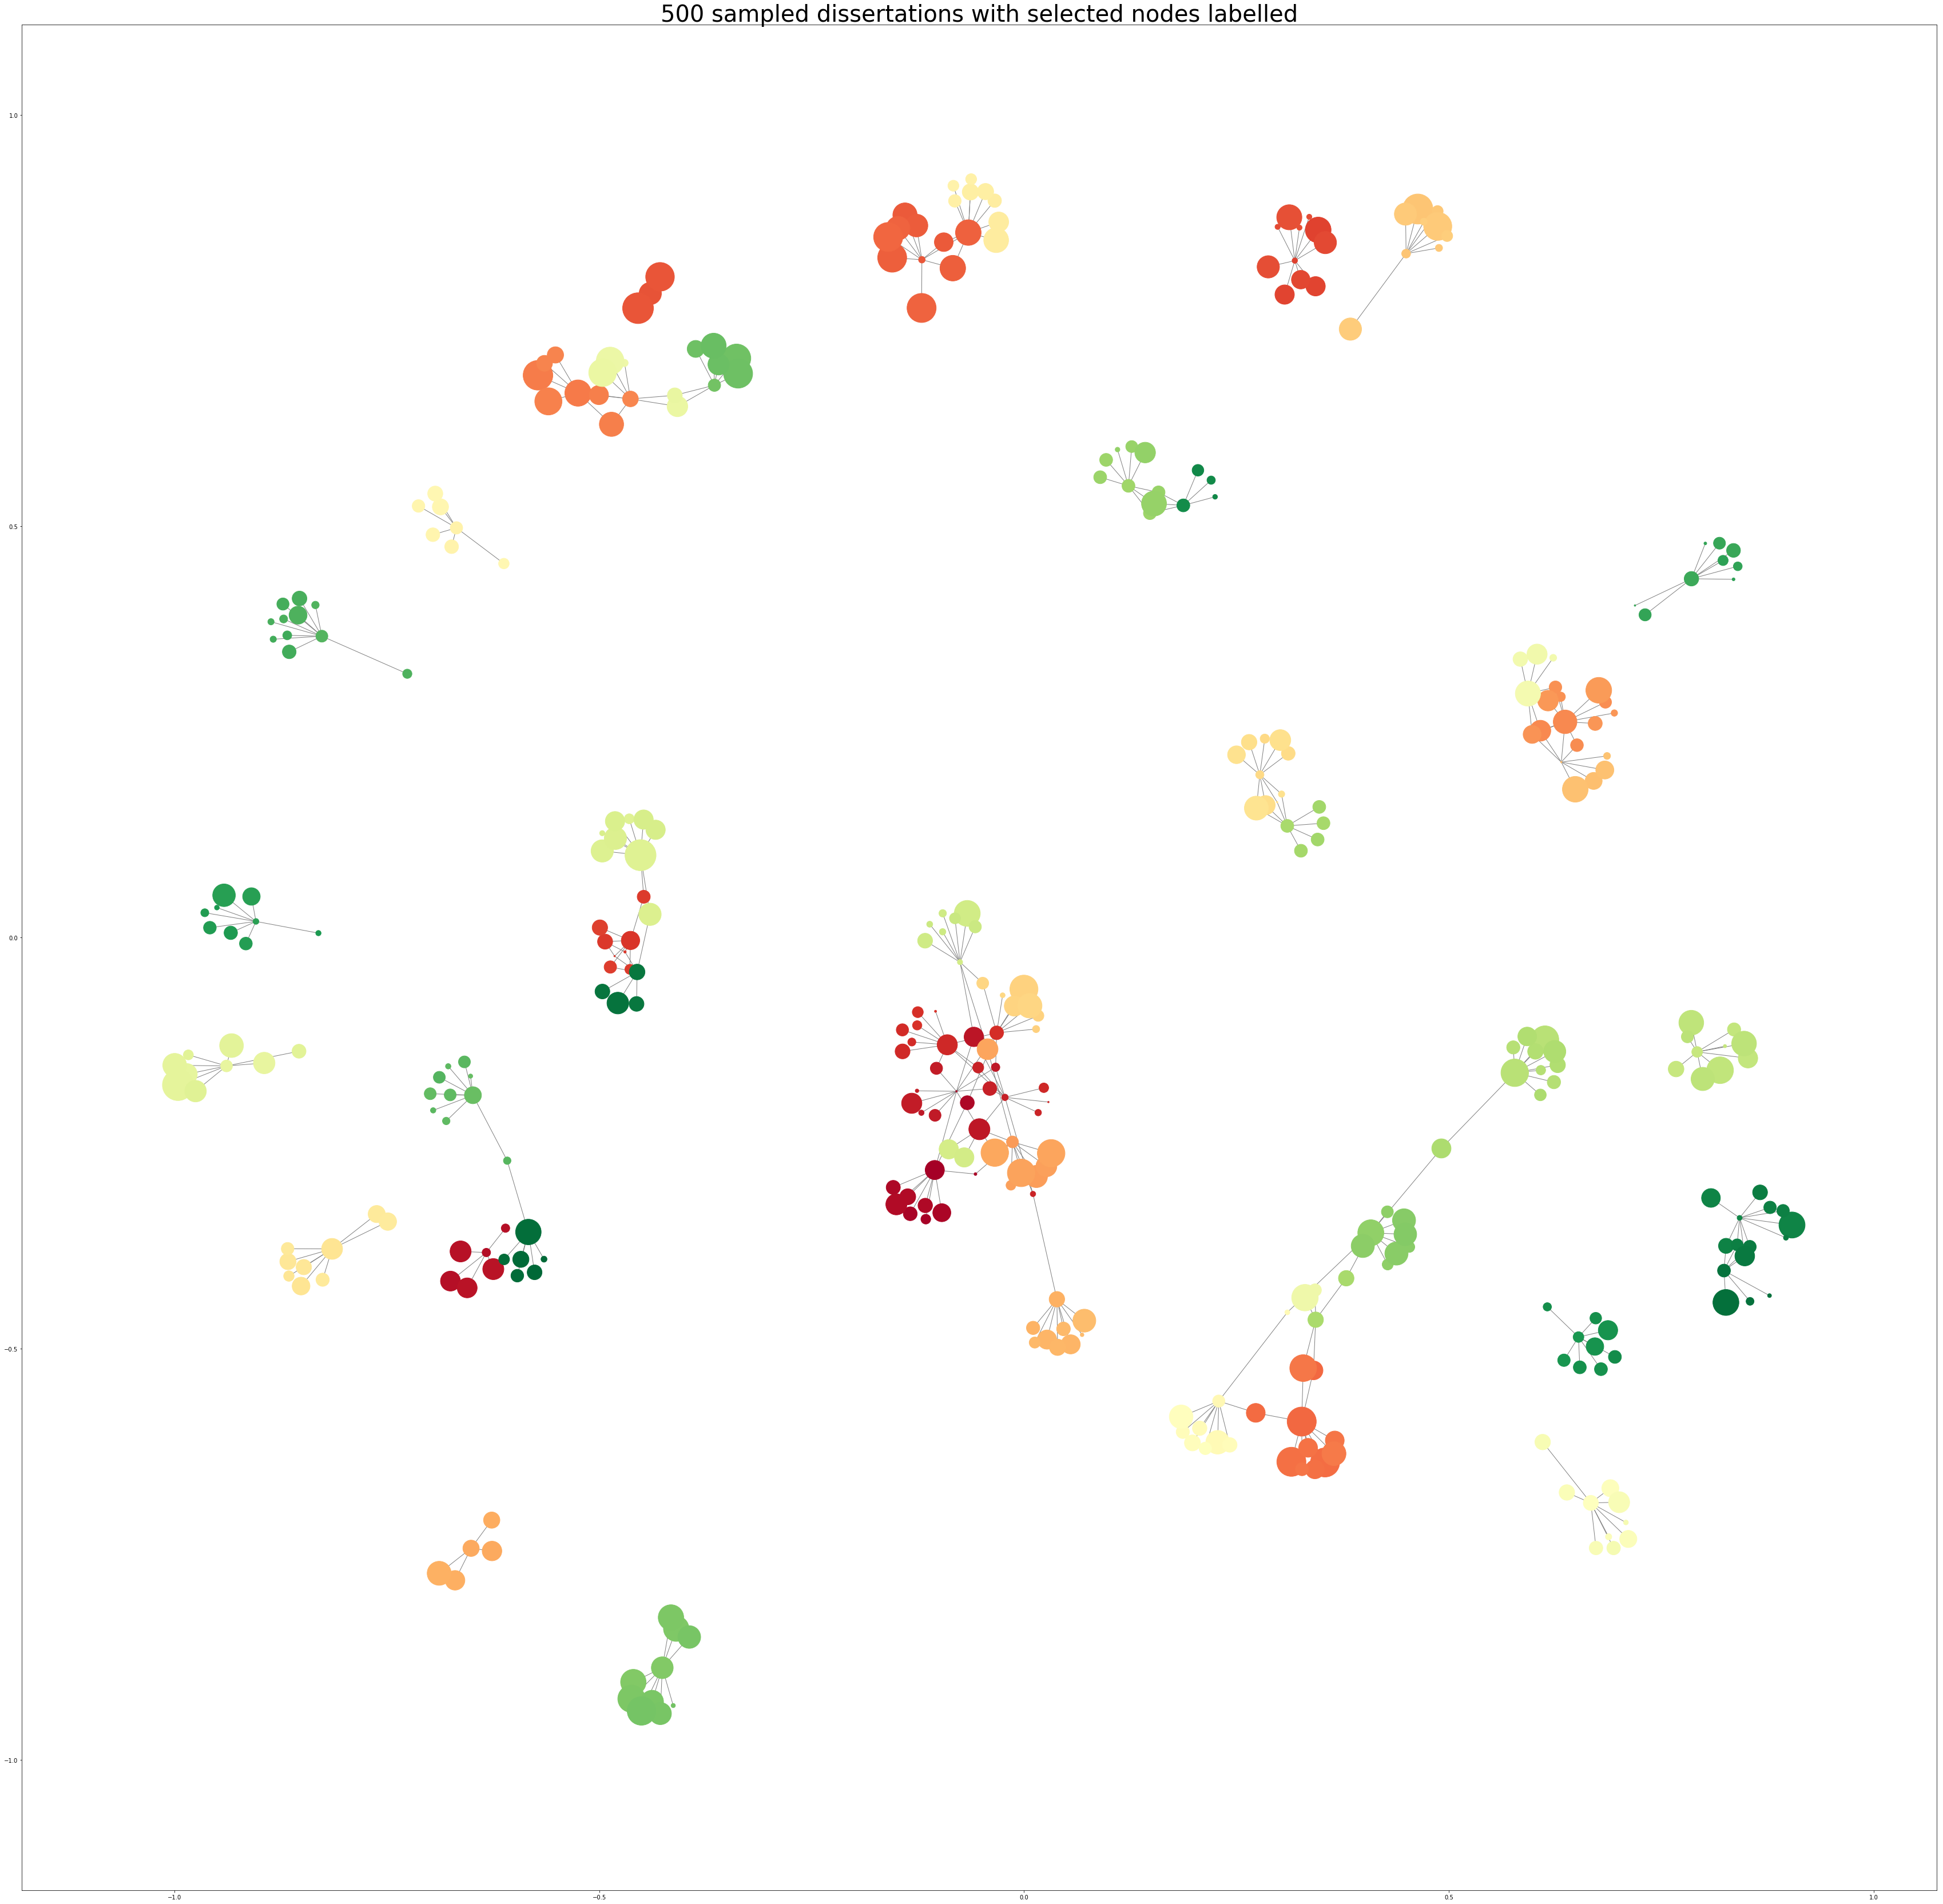

In [256]:
labels = {}    
for node in g.nodes():
    if node in cluster:
        #set the node name as the key and the label as its value 
        labels[node] = node
#set the argument 'with labels' to False so you have unlabeled graph
nx.draw_networkx(g, node_size = df4['weight1'].values * 4000, edge_color = 'grey', cmap = cmap, node_color = colors, width = 1, with_labels=False)
#Now only add labels to the nodes you require (the hubs in my case)
#nx.draw_networkx_labels(g, labels, font_size=16,font_color='b')
plt.title("500 sampled dissertations with selected nodes labelled", fontsize = 40)
plt.gcf().set_size_inches(60, 60)
plt.show()

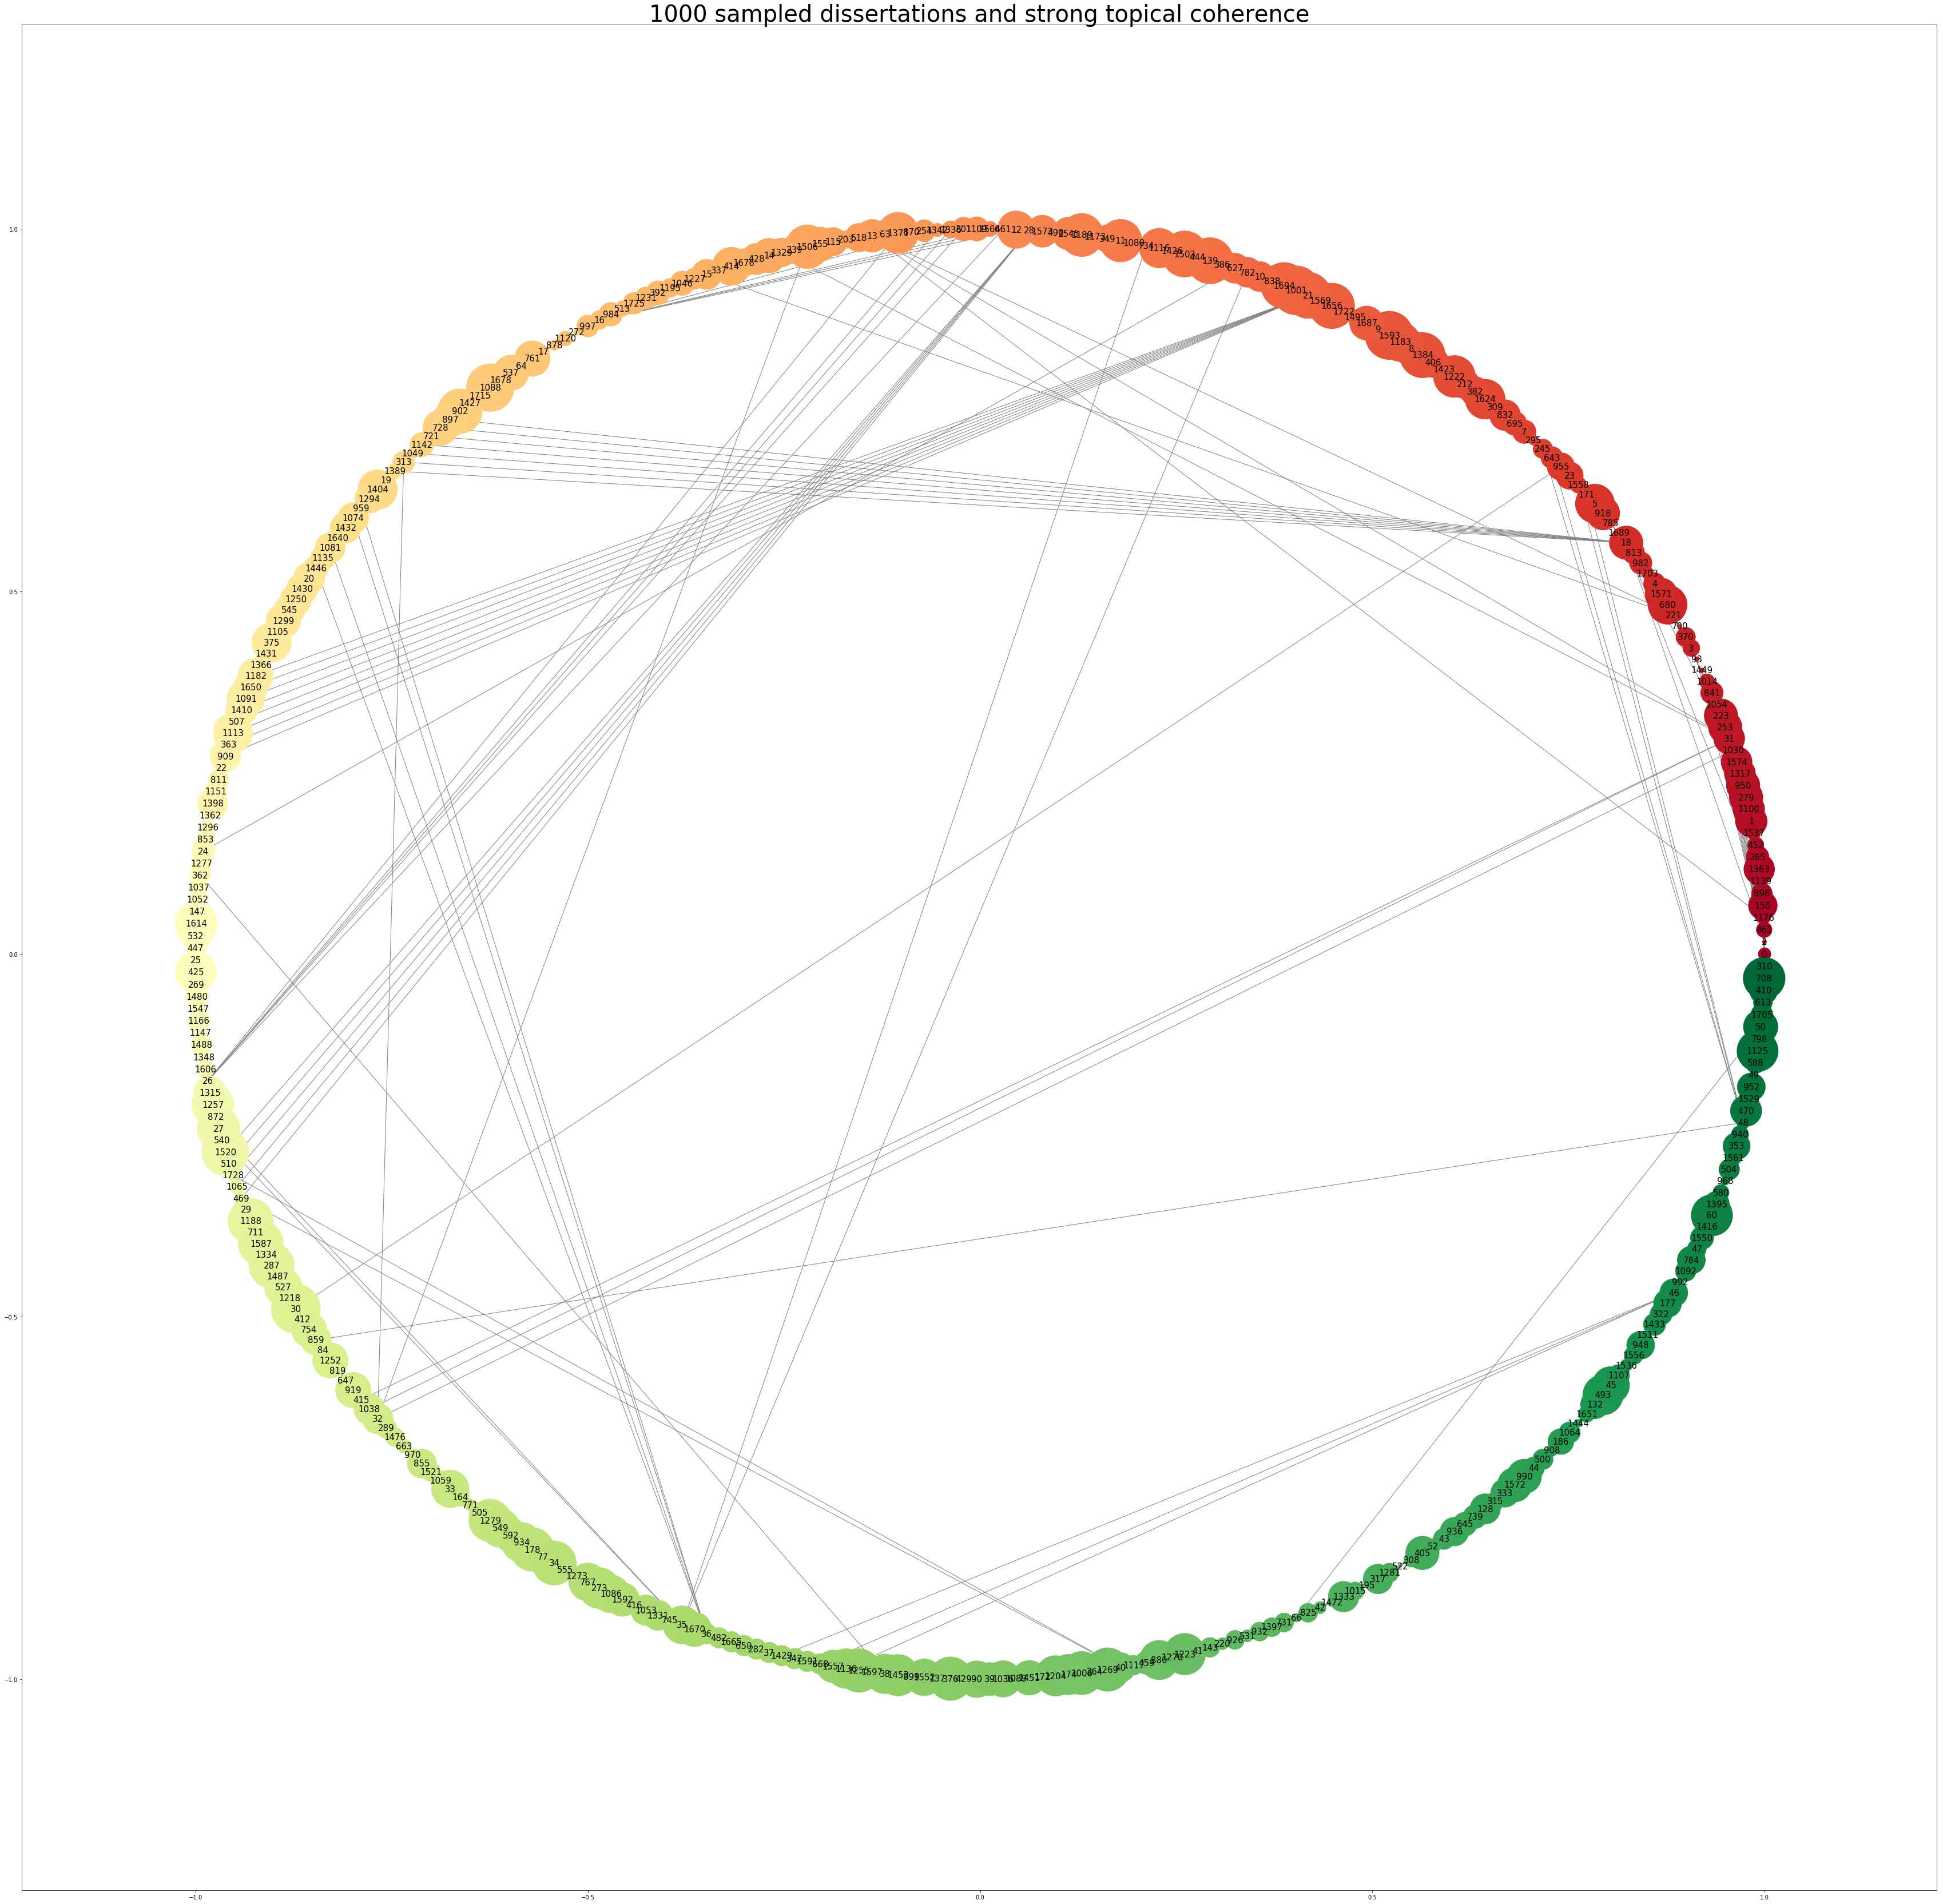

In [221]:
pos = nx.circular_layout(g)
nx.draw_networkx(g, pos, node_size = df4['weight1'].values * 10000, edge_color = 'grey', cmap = cmap, node_color = colors, font_size = 15, width = 1)
plt.title("500 sampled dissertations and strong topical coherence", fontsize = 40)
plt.gcf().set_size_inches(60, 60)
plt.show()

The circular layout shows which nodes as pulling in all the others. These are the sampled nodes and pull in linked nodes which share the same top three topic. 

We chose to assign dissertations the role of nodes. A node list is a set of objects that consists of a list of all the individual dissertations (nodes).